# RQs - LintQ - Analyzing Quantum Programs
This notebook contains the results of the analysis of quantum programs with the LintQ checkers.
The research questions and the main claims of the paper can be reproduced by running this code.

In [1]:
import project_path
from rdlib import *  # this imports the base libraries

import glob
from typing import Dict, List
import re
import yaml
from tqdm import tqdm


In [8]:
# dataset
DIR_DATASET_QISKIT = '../data/datasets/exp_v08'
LOG_FILE_QUERIES = '../data/analysis_results/exp_v08/codeql_2023-03-20_19-13-27/log.txt'
LOG_FILE_DB_CREATION = '../data/datasets/exp_v08/log_codeql.txt'
PATH_YAML_EXPERIMENT = '../config/dataset_creation_exp_v08.yaml'

# output
PAPER_DIR = '../data/paper_images'

# Abstraction
DETECTORS_FOLDER = '../qlint/codeql/src'
ABSTRACTION_FOLDER = '../qlint/codeql/lib/qiskit'

# warning & manual inspection
PATH_WARNINGS_SARIF = '../data/analysis_results/exp_v08/codeql_2023-03-20_19-13-27/data.sarif'
PATH_MANUAL_INSPECTION_CSV = '../data/annotations/manual_inspection/warnings_until_23_03_29.csv'
PATH_METADATA_DATASET = '../data/datasets/exp_v08/df_summary.csv'
PATH_WARNINGS_CSV_NEW = PATH_WARNINGS_SARIF.replace(".sarif", ".csv")
PATH_OUTPUT_EXTENDED_TP_DESCRIPTION = '../bug_reports/true_positives_found'

# competitor
PATH_QSMELL_RESULTS = "../data/datasets/exp_v08/qsmell"

# NAME MAPPING: for uniformity of names
# the order of this values is also the order of the checkers in the figures.
NAME_MAPPING = {
    'ql-double-measurement': 'DoubleMeas',
    'DoubleMeasurement.ql': 'DoubleMeas',

    'ql-operation-after-measurement': 'OpAfterMeas',
    'OpAfterMeasurement.ql': 'OpAfterMeas',

    'ql-measure-all-abuse': 'MeasAllAbuse',
    'MeasureAll.ql': 'MeasAllAbuse',


    'ql-incompatible-composition': 'IncompCompose',
    'IncompatibleComposition.ql': 'IncompCompose',

    'ql-ungoverned-composition': 'UngovCompose',
    'UngovernedComposition.ql': 'UngovCompose',

    'ql-ghost-composition': 'GhostCompose',
    'GhostComposition.ql': 'GhostCompose',


    'ql-unmeasurable-qubits': 'InsuffClasReg',
    'UnmeasurableQubits.ql': 'InsuffClasReg',

    'ql-oversized-circuit': 'OversizedCircuit',
    'OversizedCircuit.ql': 'OversizedCircuit',

    'ql-op-after-optimization': 'OpAfterTransp',
    'OpAfterOptimization.ql': 'OpAfterTransp',


    'qsmell-nc': 'QSmellNC',
    'qsmell-lpq': 'QSmellLPQ',


    # 'InvalidPauliErrorSize.ql': 'InvPauliError',
    # 'ql-invalid-pauli-size-error': 'InvPauliError',

    # 'InvalidPauliSyntaxError.ql': 'InvPauliSyntax',
    # 'ql-invalid-pauli-string': 'InvPauliSyntax',
}


RULE_NAME_MAPPING = {
    k: v for k, v in NAME_MAPPING.items() 
    if k.startswith('ql-') or k.startswith('qsmell-')
}
FILE_NAME_RULE_MAPPING = {
    k: v for k, v in NAME_MAPPING.items() 
    if k.endswith('.ql')
}

# BLACKLIST OF DATA WHICH REFER TO OBSOLETE INSPECTIONS/ IMPLEMENTATIONS
BLACKLIST_EXPERIMENTS = ['exp_v00']
BLACKLISTED_QUERIES = [
    '/Vulnerability/TokenLeakage.ql',
    '/Simulation/InvalidPauliErrorSize.ql',
    '/Simulation/InvalidPauliSyntaxError.ql',]
BLACKLISTED_RULES = [
    'ql-token-leakage',
    'ql-invalid-pauli-size-error',
    'ql-invalid-pauli-string',
]
BLACKLISTED_ABSTRACTION = [
    '/SensitiveAPI.qll',
    '/NoiseModel.qll',
    '/Pauli.qll',
]

In [9]:
# PLOT THE FILTERING STEPS OF THE DATASET
with open(PATH_YAML_EXPERIMENT, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
# ../data/datasets/exp_v08/intermediate_results
names_of_processing_steps = [p['name'] for p in config['processing_steps']]
n_files_prev_step = None
for step_name in names_of_processing_steps:
    step_dir = os.path.join(
        "..", config['dataset_folder'], 
        'intermediate_results', step_name, "files")
    # remove _ and space capitalize the first letter of each word
    step_name = step_name.replace("_", " ").title().replace(" ", "")
    n_files_in_dir = len([
        f for f in os.listdir(step_dir) 
        if os.path.isfile(
            os.path.join(step_dir, f)
        )])
    # print the number of files in the format 1'000
    print("\\newcommand{\\" + step_name + "}{" + f"{n_files_in_dir:,}" + "}")
    if n_files_prev_step is not None:
        # compute the percentage reduction with respect to the previous step
        perc_red = ((n_files_prev_step - n_files_in_dir) / n_files_prev_step) * 100
        print("\\newcommand{\\" + step_name + "Reduction}{" + f"{perc_red:.1f}\%" + "}")

    n_files_prev_step = n_files_in_dir

\newcommand{\RemoveTooLongFilenames}{81,862}
\newcommand{\KeepOnlyPyAndIpynb}{75,304}
\newcommand{\KeepOnlyPyAndIpynbReduction}{8.0\%}
\newcommand{\RemoveBlacklistedRepos}{41,739}
\newcommand{\RemoveBlacklistedReposReduction}{44.6\%}
\newcommand{\ConvertIpynbToContentOnly}{36,614}
\newcommand{\ConvertIpynbToContentOnlyReduction}{12.3\%}
\newcommand{\Parsable}{19,260}
\newcommand{\ParsableReduction}{47.4\%}
\newcommand{\AddHashOfTheContent}{19,260}
\newcommand{\AddHashOfTheContentReduction}{0.0\%}
\newcommand{\HashDeduplication}{14,494}
\newcommand{\HashDeduplicationReduction}{24.7\%}
\newcommand{\IncludeImport}{8,743}
\newcommand{\IncludeImportReduction}{39.7\%}
\newcommand{\ExcludePlatformCode}{7,587}
\newcommand{\ExcludePlatformCodeReduction}{13.2\%}
\newcommand{\UnrollLoops}{7,567}
\newcommand{\UnrollLoopsReduction}{0.3\%}


## Helper Function

In [10]:
import os

def get_file_extension_dictionary(dir: str) -> dict:
    """Get a dictionary {filename: its extension, etc.} form a directory."""
    file_extensions = {}
    for file in os.listdir(dir):
        base_name = os.path.splitext(file)[0]
        extension = os.path.splitext(file)[1]
        file_extensions[base_name] = extension
    return file_extensions

def create_pandas(file_extensions: dict) -> pd.DataFrame:
    """Create a pandas dataframe from a dictionary {filename: its extension, etc.}."""
    df = pd.DataFrame.from_dict(file_extensions, orient='index', columns=['extension'])
    df['filename'] = df.index
    # drop index
    df.reset_index(drop=True, inplace=True)
    df['filename'] = df['filename'].astype(str)
    df['extension'] = df['extension'].astype(str)
    return df

def get_stats_on(dataset_folder: str, platform_name: str):
    """Print the summary stats of the given folder."""

    ext_dict_selected = get_file_extension_dictionary(
        dir=os.path.join(dataset_folder, 'files_selected'))
    df_selected = create_pandas(ext_dict_selected)

    ext_dict_all = get_file_extension_dictionary(
        dir=os.path.join(dataset_folder, 'raw_files'))
    df_all = create_pandas(ext_dict_all)

    df_merged = pd.merge(
        df_selected, df_all, 
        on='filename', how='left',
        suffixes=('_selected', '_all'))

    # countplot with percentage of py and ipynb files
    total_unique_files = df_merged.shape[0]
    total_raw_files = df_all.shape[0]
    perc_py = (df_merged[df_merged['extension_all'] == '.py'].shape[0] / total_unique_files) * 100
    perc_ipynb = (df_merged[df_merged['extension_all'] == '.ipynb'].shape[0] / total_unique_files) * 100
    print(f'Percentage of .py files: {perc_py:.1f} %')
    print(f'Percentage of .ipynb files: {perc_ipynb:.1f} %')
    print(f'Total unique files: {total_unique_files}')
    print(f'Total files (scraped): {total_raw_files}')

    print("\\newcommand{\\nProgramsScraped" + platform_name + "}{" + f"{total_raw_files:,}" + "}")
    print("\\newcommand{\\nProgramsSelected" + platform_name + "}{" + f"{total_unique_files:,}" + "}")
    print("\\newcommand{\\nProgramsPy" + platform_name + "}{" + f"{perc_py:.1f}" + "\%}")
    print("\\newcommand{\\nProgramsIpynb" + platform_name + "}{" + f"{perc_ipynb:.1f}" + "\%}")
    
    fig, ax = plt.subplots(figsize=(5, 1.5))
    sns.countplot(
        data=df_merged, 
        y='extension_all',
        order=['.py', '.ipynb'],
        ax=ax,
    )
    plt.xlabel('Number of programs')
    plt.ylabel('Extension')
    plt.tight_layout()
    fig.savefig(
        os.path.join(PAPER_DIR, f'files_per_extension_{platform_name}.pdf'))
    

def get_color_for_abstr_family(
        df: pd.DataFrame,
        col_name: str,
        format_str: str = 'hex',):
    """Get a color dict mapping each abstraction to a color.
    
    Nota that this mapping is based on the abstraciton name.
    If not specified it is grey.
    """
    # create thematic groups for source
    if format_str == 'hex':
        color_themes = {
            "pauli": "#dc267f",
            "compos": "#785ef0",
            "insuf": "#fe6100", 
            "oversize": "#fe6100",
            "[^u]?meas": "#ffb001",    
        }
    elif format_str == 'rgb':
        color_themes = {
            "pauli": "rgb(220, 38, 127)",
            "compos": "rgb(120, 94, 240)",
            "insuf": "rgb(254, 97, 0)", 
            "oversize": "rgb(254, 97, 0)",
            "[^u]?meas": "rgb(255, 176, 1)",    
        }
    per_family_color = {}
    for row in df.iterrows():
        query_name = row[1][col_name]
        # default
        per_family_color[query_name] = "grey"
        for k in color_themes.keys():
            if re.search(k, query_name.lower()):
                per_family_color[query_name] = color_themes[k]
                break
    return per_family_color

## Read Data
### Warning Produced by Checkers
Here we load the data produced by the checkers: both the LintQ and QSmell (static).

In [11]:
# LOAD LINTQ METADATA

# CREATE THE CSV VERSION OF THE FILE WITH WARNINGS
# if the PATH_WARNINGS_CSV_NEW does not exist, create it
if not os.path.exists(PATH_WARNINGS_CSV_NEW):
    ! sarif csv --output {PATH_WARNINGS_CSV_NEW} {PATH_WARNINGS_SARIF}
else:
    print("File already exists: ", PATH_WARNINGS_CSV_NEW)

df_metadata = pd.read_csv(PATH_METADATA_DATASET)
print("Metadata: ", list(df_metadata.columns))
df_metadata['unique_id'] = df_metadata.apply(
    lambda row: str(row['filestem']) + "_" + str(row['hash']), axis=1)
df_metadata = df_metadata[['unique_id', 'extension', 'repository_name']]
df_metadata.head()

# LOAD WARNINGS CONVERTED IN JSON FORMAT
df_warnings = pd.read_csv(PATH_WARNINGS_CSV_NEW)
df_warnings['rule'] = df_warnings['Code'].apply(lambda e: e.split(" ")[0])
df_warnings['unique_id'] = df_warnings['Location'].apply(lambda e: e.split(".")[0])

# merge the two dataframes keeping the df_warnings as the base
df_warnings_w_metadata = pd.merge(
    df_warnings,
    df_metadata,
    on='unique_id',
    how='left'
)
# remove blacklist rules
df_warnings_w_metadata = df_warnings_w_metadata[
    ~df_warnings_w_metadata['rule'].isin(BLACKLISTED_RULES)]

# focus on LintQ rules
df_lintq_only = df_warnings_w_metadata[
    df_warnings_w_metadata['rule'].str.startswith('ql')]
df_lintq_only.loc['rule'] = df_lintq_only['rule'].map(RULE_NAME_MAPPING)
df_lintq_checker_location = df_lintq_only[['rule', 'Location']]
# drop nan values
df_lintq_checker_location = df_lintq_checker_location.dropna()
print("LintQ rules :", list(df_lintq_checker_location['rule'].unique()))


# ------------------------------------------------------------------------------

# LOAD QSMELL WARNINGS
all_csv_files = [
    os.path.join(PATH_QSMELL_RESULTS, f)
    for f in os.listdir(PATH_QSMELL_RESULTS)
    if f.endswith(".csv")
]
df_qsmell = pd.concat([pd.read_csv(f) for f in all_csv_files])
# convert all errors to value 1000
df_qsmell.loc[df_qsmell["value"] == "error", "value"] = -1
# alarm when the value is greater than 0 and it is an integer
# convert the value to integer
df_qsmell["value"] = df_qsmell["value"].astype(int)
df_qsmell["alarm"] = (df_qsmell["value"] > 0)
# convert alarm column
# False > no smell
# True > smell warning
df_qsmell["alarm_msg"] = df_qsmell["alarm"].apply(
    lambda x: "no smell" if not x else "smell warning")
# rename:
# metric > rule
# filename > Location
df_qsmell = df_qsmell.rename(columns={
    "metric": "rule",
    "filename": "Location"
})
# keep only the rows with alarm = True
df_qsmell = df_qsmell[df_qsmell["alarm"] == True]
# map the terms in metric
mapping_metric_to_name = {
    'LPQ': 'QSmellLPQ',
    'NC': 'QSmellNC',
}
df_qsmell["rule"] = df_qsmell["rule"].map(mapping_metric_to_name)
# keep only the relevant columns
df_qsmell_checker_location = df_qsmell[["rule", "Location"]]
df_qsmell_checker_location.head()
print("QSmell rules :", list(df_qsmell_checker_location['rule'].unique()))

# ALL CHECKERS WARNINGS
df_all_checker_location = pd.concat([
    df_lintq_checker_location,
    df_qsmell_checker_location
])
df_all_checker_location.head()

File already exists:  ../data/analysis_results/exp_v08/codeql_2023-03-20_19-13-27/data.csv
Metadata:  ['download_url', 'html_url', 'name', 'path', 'repository_description', 'repository_fork', 'repository_name', 'repository_owner_url', 'repository_url', 'score', 'filename', 'extension', 'filestem', 'hash', 'unique_id']
LintQ rules : ['ql-double-measurement', 'ql-ghost-composition', 'ql-incompatible-composition', 'ql-measure-all-abuse', 'ql-op-after-optimization', 'ql-operation-after-measurement', 'ql-oversized-circuit', 'ql-unmeasurable-qubits']
QSmell rules : ['QSmellLPQ', 'QSmellNC']


/tmp/ipykernel_16825/4166056372.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lintq_only.loc['rule'] = df_lintq_only['rule'].map(RULE_NAME_MAPPING)


,rule,Location
0,ql-double-measurement,example_d675c9.py
1,ql-double-measurement,example_d675c9.py
2,ql-double-measurement,02_measurements_and_mixed_states_qiskit_ee25f6.py
3,ql-double-measurement,qubitstates_903372.py
4,ql-double-measurement,computaci_c3_b3n_cu_c3_a1ntica_pr_c3_a1ctica_c...


### Manual Inspection 
Here we load the data regarding the warnings we have inspected.

In [12]:
# MANUAL INSPECTION
df_inspected_warnings = pd.read_csv(PATH_MANUAL_INSPECTION_CSV)
# filter out old runs of experiments
df_inspected_warnings = df_inspected_warnings[
    ~df_inspected_warnings["experiment"].isin(BLACKLIST_EXPERIMENTS)]
# filter out blacklisted outdated checkers
df_inspected_warnings = df_inspected_warnings[
    ~df_inspected_warnings["detector_rule"].isin(BLACKLISTED_RULES)]
# map the detector_rule with dict: RULE_NAME_MAPPING
df_inspected_warnings['detector_rule'] = \
    df_inspected_warnings['detector_rule'].map(RULE_NAME_MAPPING)
df_inspected_warnings.head()


# count how many files we have in the dataset
ext_dict_selected = get_file_extension_dictionary(
    dir=os.path.join(DIR_DATASET_QISKIT, 'files_selected'))
df_selected = create_pandas(ext_dict_selected)
ext_dict_all = get_file_extension_dictionary(
    dir=os.path.join(DIR_DATASET_QISKIT, 'raw_files'))
df_all = create_pandas(ext_dict_all)
df_merged = pd.merge(
    df_selected, df_all, 
    on='filename', how='left',
    suffixes=('_selected', '_all'))
TOTAL_FILES_IN_DATASET = df_merged.shape[0]
print(f"Total files in dataset: {TOTAL_FILES_IN_DATASET}")

Total files in dataset: 7568


Percentage of .py files: 85.8 %
Percentage of .ipynb files: 14.2 %
Total unique files: 7568
Total files (scraped): 81862
\newcommand{\nProgramsScrapedQiskit}{81,862}
\newcommand{\nProgramsSelectedQiskit}{7,568}
\newcommand{\nProgramsPyQiskit}{85.8\%}
\newcommand{\nProgramsIpynbQiskit}{14.2\%}


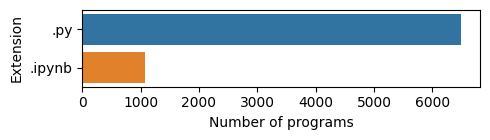

In [13]:
get_stats_on(
    dataset_folder=DIR_DATASET_QISKIT,
    platform_name='Qiskit')

In [19]:
# GENERATE THE EXTENDED SUMMARY OF THE ANNOTATED PROBLEMS
PATH_TO_FILES = os.path.join(DIR_DATASET_QISKIT, 'files_selected')
df = df_inspected_warnings.copy()
df_tp = df[df['triage'] == 'TP']
df_tp.head()

def get_file_content(
        file_path: str, central_line: int = 0, 
        lines_before: int = 11, lines_after: int = 11):
    """Return the file content and the lines around it.
    
    Note that if the range is larger, it returns up to the entire file.
    """
    with open(file_path, 'r') as f:
        content = f.read()
    lines = content.splitlines()
    start = int(max(0, central_line - lines_before))
    end = int(min(len(lines), central_line + lines_after))
    relative_target_line = central_line - start
    return content, lines[start:end], relative_target_line
    
df_tp.reset_index(inplace=True)
# creates a markdown for each row
for i, row in tqdm(df_tp.iterrows()):
    output_file_path = os.path.join(
        PATH_OUTPUT_EXTENDED_TP_DESCRIPTION, row['problem_id'] + ".md")
    target_line = int(row['line'])
    # shift the target lint +1 in case the location was referring to 
    # the experiment v06, namely the program id starts with 06
    url = row['url']
    content, relevant_lines, relative_target_line = get_file_content(
        file_path=os.path.join(PATH_TO_FILES, row['unique_id'].strip() + ".py"),
        central_line=row['line'])
    checker = row['detector_rule']
    with open(output_file_path, 'w') as f:
        f.write(f"# {row['problem_id']}\n")
        f.write(f" - URL: {url}\n")
        # add separator
        f.write(f"---\n")
        f.write(f" - **Checker**: {checker}\n")
        f.write(f" - **Problem Description**: {row['problem_description']}\n")
        f.write(f" - **Intended Behavior**: {row['intended_behavior']}\n")
        f.write(f" - **Additional Comments**: {row['more_info']}\n")
        f.write(f" - **Relevant Lines**:\n")
        # python code
        f.write(f"```python\n")
        # add a comment <=== PROBLEM LOCATION
        # at the target line
        for i, line in enumerate(relevant_lines):
            if i == relative_target_line - 1:
                f.write(f"   {line}  # <=== PROBLEM LOCATION\n")
            else:
                f.write(f"   {line}\n")
        f.write(f"```")

31it [00:00, 353.05it/s]


## RQ1: Modeling Info: Abstractions and Queries
- How many CodeQL LoC per checker. 
- Avg number of abstractions used. >> bipartite graph.


In [20]:
def read_files(folder: str, extension: str = ".ql") -> Dict[str, str]:
    """Read all files with the given extension in the folder and subfolders."""
    ql_files = {}
    for file in glob.glob(folder + f'/**/*{extension}', recursive=True):
        with open(file, 'r') as f:
            content = f.read()
            ql_files[file.replace(folder, "")] = content
    return ql_files

def get_abstractions_used(content: str) -> List[str]:
    """Get the abstractions used in the given content."""
    abstractions = []
    for line in content.splitlines():
        if line.startswith('import'):
            abstraction = line.split(' ')[1]
            abstractions.append(abstraction)
    return abstractions

In [21]:
query_files = read_files(
    folder=DETECTORS_FOLDER, extension='.ql')
abstraction_files = read_files(
    folder=ABSTRACTION_FOLDER, extension='.qll')

# remove all the blacklisted queries
query_files = {
    k: v for k, v in query_files.items() 
    if k not in BLACKLISTED_QUERIES}

# remove all the blacklisted abstractions
abstraction_files = {
    k: v for k, v in abstraction_files.items() 
    if k not in BLACKLISTED_ABSTRACTION}

print(f'Number of queries: {len(query_files)}')
print(f'Number of abstractions: {len(abstraction_files)}')
all_query_names = list(query_files.keys())
print(all_query_names)

all_abstractions_names = list(abstraction_files.keys())
print(all_abstractions_names)

Number of queries: 11
Number of abstractions: 4
['/Measurement/OpAfterMeasurement.ql', '/Measurement/MeasureAll.ql', '/Measurement/DoubleMeasurement.ql', '/Qsmell/NoAlignmentLogicalPhysical.ql', '/Qsmell/NonParametrizedCircuit.ql', '/Resource/OversizedCircuit.ql', '/Resource/UnmeasurableQubits.ql', '/Interconnection/IncompatibleComposition.ql', '/Interconnection/UngovernedComposition.ql', '/Interconnection/GhostComposition.ql', '/Optimization/OpAfterOptimization.ql']
['/Register.qll', '/Qubit.qll', '/Circuit.qll', '/Gate.qll']


### RQ1.A Which abstractions are used in the different queries?

In [22]:
def get_abstractions_from_qll(content: str) -> List[str]:
    """Get the abstractions used in the given content.
    
    It uses regex."""
    # all_abstractions = re.findall(r'class (\w+)', content)
    public_abstractions = re.findall(r'^class (\w+)', content, re.MULTILINE)
    return public_abstractions

all_abstraction_defined = []
for abstraction_file in abstraction_files.values():
    all_abstraction_defined += get_abstractions_from_qll(abstraction_file)

print(f'Number of abstractions defined: {len(all_abstraction_defined)}')
print(all_abstraction_defined)

Number of abstractions defined: 9
['ClassicalRegister', 'QuantumRegister', 'QubitUsedInteger', 'QuantumCircuit', 'TranspiledCircuit', 'Gate', 'MeasureGate', 'MeasurementAll', 'MeasurementAny']


In [23]:
def check_abstractions_used(abstraction: List[str], content: str) -> bool:
    """Check if the given abstraction is used in the content.
    
    Via regex.
    """
    abstractions_used = []
    for a in abstraction:
        if re.search(rf'\b{a}\b', content):
            abstractions_used.append(a)
    return abstractions_used


query_to_abstraction = {}

# remove Qsmell classes
query_files = {
    k: v for k, v in query_files.items() 
    if not k.startswith('/Qsmell/')}

for query_name, query_content in query_files.items():
    abstractions_used = check_abstractions_used(
        abstraction=all_abstraction_defined, 
        content=query_content)
    if abstractions_used:
        base_name = os.path.basename(query_name)
        if base_name in FILE_NAME_RULE_MAPPING:
            base_name = FILE_NAME_RULE_MAPPING[base_name]
        query_to_abstraction[base_name] = abstractions_used
        print(f'{query_name}: {abstractions_used}')


/Measurement/OpAfterMeasurement.ql: ['Gate', 'MeasureGate']
/Measurement/MeasureAll.ql: ['QuantumCircuit', 'MeasurementAll']
/Measurement/DoubleMeasurement.ql: ['Gate', 'MeasureGate']
/Resource/OversizedCircuit.ql: ['QuantumRegister', 'QubitUsedInteger', 'QuantumCircuit', 'MeasureGate']
/Resource/UnmeasurableQubits.ql: ['QuantumRegister', 'QuantumCircuit']
/Interconnection/IncompatibleComposition.ql: ['QuantumCircuit']
/Interconnection/UngovernedComposition.ql: ['QuantumCircuit']
/Interconnection/GhostComposition.ql: ['QuantumCircuit']
/Optimization/OpAfterOptimization.ql: ['TranspiledCircuit', 'Gate']


,source,target,type,value
0,OpAfterMeas,Gate,use,1
1,OpAfterMeas,MeasureGate,use,1
2,MeasAllAbuse,QuantumCircuit,use,1
3,MeasAllAbuse,MeasurementAll,use,1
4,DoubleMeas,Gate,use,1


\newcommand{\avgAbstractionsUsedPerQuery}{1.5}
\newcommand{\avgQueriesSupportedPerAbstraction}{2.4}


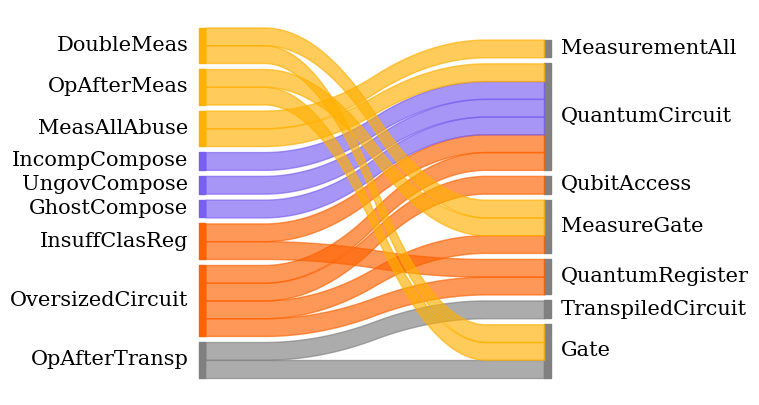

In [24]:
# get matplotlib rc configuration
rc = plt.rcParams.copy()

from pySankey.sankey import sankey
# source,target,type,value

records = []
for query_name, abstractions in query_to_abstraction.items():
    for abstraction in abstractions:
        if abstraction == "QubitUsedInteger":
            abstraction = "QubitAccess"
        records.append({
            'source': query_name,
            'target': abstraction,
            'type': 'use',
            'value': 1,
        })
df_abstractions = pd.DataFrame.from_records(records)
display(df_abstractions.head())
# sort by canonical order
df_abstractions['source'] = pd.Categorical(
    df_abstractions['source'],
    categories=RULE_NAME_MAPPING.values()
)
df_abstractions = df_abstractions.sort_values('source', ascending=False)
df_abstractions.head()
# compute the average number of records per source 
use_relationship_per_query = df_abstractions.groupby('source').count()['value']
#print(use_relationship_per_query)
avg_use_relationship_per_query = use_relationship_per_query.mean()
print("\\newcommand{\\avgAbstractionsUsedPerQuery}{" + f"{avg_use_relationship_per_query:.1f}" + "}")
avg_use_relationship_per_abstraction = df_abstractions.groupby('target').count()['value'].mean()
print("\\newcommand{\\avgQueriesSupportedPerAbstraction}{" + f"{avg_use_relationship_per_abstraction:.1f}" + "}")

per_family_color = get_color_for_abstr_family(
    df=df_abstractions,
    col_name='source',
)

# colorDict: yellow for target and blue for source
colorDict = {
    #**{k: 'slateblue' for k in df_abstractions['source'].unique()}, 
    **per_family_color,
    **{k: 'gray' for k in df_abstractions['target'].unique()}
}

sankey(
    left=df_abstractions['source'],
    right=df_abstractions['target'],
    aspect=20,
    colorDict=colorDict,
    fontsize=15,
)
plt.gcf().set_size_inches(5, 5)
plt.savefig(
    os.path.join(PAPER_DIR, 'sankey_abstraction.pdf'),
    bbox_inches='tight')

# go back to the initial rc configuration
plt.rcParams.update(rc)

### RQ1.B Count LoC Files

\newcommand{\avgLoCQuery}{13.3}
\newcommand{\minLoCQuery}{6}
\newcommand{\maxLoCQuery}{20}


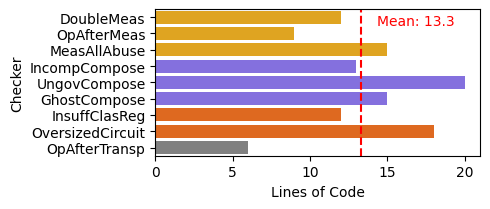

In [25]:
SHOW_QUERIES_DEBUG = False

records = []
for query_name, query_content in query_files.items():
    # count the lines in the content excluding the imports and the comment lines
    # comment start with: /* or * or //
    # imports start with: import
    lines = query_content.splitlines()
    lines = [
        line for line in lines
        # use regex to ensure we account for spaces
        if not re.match(r'^\s*import', line) and
        not re.match(r'^\s*//', line) and
        not re.match(r'^\s*\*', line) and
        not re.match(r'^\s*/\*', line)  
    ]
    # remove empty lines
    lines = [l for l in lines if l != '']
    loc = len(lines)
    if SHOW_QUERIES_DEBUG:
        print("\n".join(lines))
        print(query_name, loc)
        # check that none of the line is longer than 80 chars
        for line in lines:
            if len(line) > 80:
                print("___________________ line too long: ", line)
    base_query_name = os.path.basename(query_name)
    records.append({
        'query_name': FILE_NAME_RULE_MAPPING[base_query_name],
        'loc': loc
    })

df_loc_queries = pd.DataFrame.from_records(records)
# sort by canonical order
categories = [
    cat for cat in RULE_NAME_MAPPING.values()
    if "QSmell" not in cat
]
df_loc_queries['query_name'] = pd.Categorical(
    df_loc_queries['query_name'], categories=categories)
df_loc_queries = df_loc_queries.sort_values('query_name')

per_family_color = get_color_for_abstr_family(
    df=df_loc_queries,
    col_name='query_name',
)

# plot the lines of code histogram
fig, ax = plt.subplots(figsize=(5, 2.2))
sns.barplot(
    data=df_loc_queries,
    y='query_name',
    x='loc',
    palette=per_family_color.values(),
    # sort
    #order=df_loc_queries.sort_values('loc', ascending=True)['query_name'],
)
ax.set_xlabel('Lines of Code')
ax.set_ylabel('Checker')
mean_value = df_loc_queries['loc'].mean()
# add red line for the mean
ax.axvline(mean_value, color='red', linestyle='--')
# plot the label of the mean
ax.text(
    mean_value + 1,
    0.5,
    f'Mean: {mean_value:.1f}',
    color='red',
)
plt.tight_layout()
fig.savefig(
    os.path.join(PAPER_DIR, 'loc_queries.pdf')
)
print("\\newcommand{\\avgLoCQuery}{" + f"{mean_value:.1f}" + "}")
min_value = df_loc_queries['loc'].min()
print("\\newcommand{\\minLoCQuery}{" + f"{min_value:.0f}" + "}")
max_value = df_loc_queries['loc'].max()
print("\\newcommand{\\maxLoCQuery}{" + f"{max_value:.0f}" + "}")


## RQ2: Real Bugs Found

In [43]:
# create latex table
from copy import deepcopy
import string

df_bugs = pd.read_csv(PATH_MANUAL_INSPECTION_CSV)
df_bugs = df_bugs.sort_values(by=[
    "status", "detector_rule"
], ascending=[True, False])
df_bugs = df_bugs.reset_index(drop=True)
df_bugs = df_bugs.reset_index(drop=False)
df_bugs = df_bugs.fillna("-")

ANONYMOUS = True
REMOVE_FALSE_POSITIVES = True
REMOVE_NOTEWORTHY = True
REMOVE_UNANNOTATED = True
KEEP_ONLY_REPORTED_OR_MORE = True
DROP_DUPLICATE_MESSAGES_FROM_REPORTED = True

# remove blacklisted detecotrs
df_bugs = df_bugs[~df_bugs["detector_rule"].isin(BLACKLISTED_RULES)]

col_renaming = {
    "index": "ID",
    "problem_description": "Problem description",
    "detector_rule": "Checker",
    #"API_usage": "API usage",
    "manifestation": "Manifestation",
    #"component": "Where",
    "problem_id": "Problem ID",
    "link_to_issue": "Issue",
    "status": "Status",
    #"known_before": "Novelty",
    #"triage": "Triage",
}

if ANONYMOUS:
    # remove the key "link_to_issue" from the dictionary
    del col_renaming["link_to_issue"]
    col_renaming["problem_id"] = "Issue"
    column_format = '@{}lp{7.3cm}p{2.5cm}lll@{}'
else:
    column_format = '@{}rlp{7.3cm}p{2.5cm}lll@{}'

pd.set_option('display.max_colwidth', 1000)

relevant_columns = col_renaming.keys()
df_table = deepcopy(df_bugs)
if REMOVE_FALSE_POSITIVES:
    df_table = df_table[~(df_table["triage"] == "FP")]
if REMOVE_NOTEWORTHY:
    df_table = df_table[~(df_table["triage"] == "Noteworthy")]
if REMOVE_UNANNOTATED:
    df_table = df_table[~(df_table["triage"] == "-")]
df_table = df_table.drop(columns='index')  

# def replace_MR_names(transf_str):
#     new_transf_str = transf_str
#     for k, v in MR_ALIAS.items():
#         new_transf_str = new_transf_str.replace(k, v)
#     return new_transf_str

# df_table["mr_used"] = df_table["mr_used"].apply(
#     lambda e: replace_MR_names(transf_str=e)
# ) 


# replace fixed with the url and fixed
df_table["status"] = df_table["status"].apply(
    lambda e: "fixed" if "fixed" in e else e
)

if KEEP_ONLY_REPORTED_OR_MORE:
    df_table = df_table[
        (df_table["status"] == "confirmed") |
        (df_table["status"] == "fixed") | 
        (df_table["status"] == "reported")
    ]

if DROP_DUPLICATE_MESSAGES_FROM_REPORTED:
    df_reported_only = df_table[(df_table["status"] == "reported")]
    df_rest = df_table[(df_table["status"] != "reported")]
    df_reported_only = df_reported_only.drop_duplicates(
        subset=["problem_description"])
    df_table = pd.concat([df_rest, df_reported_only])



df_table = df_table.reset_index(drop=True)
df_table = df_table.reset_index(drop=False)
print(col_renaming.keys())
print(df_table.columns)
df_table = df_table[relevant_columns].rename(columns=col_renaming)
df_table["ID"] = df_table["ID"].apply(lambda e: int(e) + 1)
# cut the column with detector
df_table["Checker"] = df_table["Checker"].map(RULE_NAME_MAPPING)
# sort by Detector



mapping_numbers = {
    "1": "One",
    "2": "Two",
    "3": "Thr",
    "4": "Fou",
    "5": "Fiv",
    "6": "Six",
    "7": "Sev",
    "8": "Eig",
    "9": "Nin",
    "0": "Zer",
}

print("% RQ2")
for i, row in df_table.iterrows():
    msg = row["Issue"]
    # remove underscores
    msg = msg.replace("_", "")
    for k, v in mapping_numbers.items():
        msg = msg.replace(k, v)
    # msg = msg.translate(str.maketrans('', '', string.punctuation))
    # msg = ''.join([w.capitalize() for w in msg.lower().split()])
    # msg = ''.join(ch for ch in msg if ch.isalpha())
    if msg != "":
        print("\\newcommand{\\ID" + msg + "}{" + str(row["ID"]) + "}")

print("")
table_code = df_table.to_latex(
    column_format=column_format,
    index=False)
table_code = re.sub("\s'", " `", table_code)
# replace all links with a \url{} command
table_code = re.sub("(https:[^ ]*)", r"\\href{\1}{link}", table_code)
print(table_code)
df_table

dict_keys(['index', 'problem_description', 'detector_rule', 'manifestation', 'problem_id', 'status'])
Index(['index', 'problem_id', 'url', 'snippet', 'experiment',
       'present_in_last_experiment', 'unique_id', 'line', 'date_found',
       'analysis_results', 'detector_rule', 'summary', 'more_info',
       'intended_behavior', 'triage', 'problem_description', 'FP_reason',
       'manifestation', 'status', 'added_to_test_suite', 'IDEA',
       'date_reported', 'API_usage', 'link_to_issue', 'developer_reaction',
       'developer comment', 'component', 'known_before'],
      dtype='object')
% RQ2
\newcommand{\IDZerEigcFivZerSevThrFouFouOneTwo}{1}
\newcommand{\IDZerSixfeSixZerZerNinSixThr}{2}
\newcommand{\IDZerSixOneThrbaEigZerNinZer}{3}
\newcommand{\IDZerSixOneThrbaEigZerOneZerSev}{4}
\newcommand{\IDZerSixFoucNinFouFouThrThrFiv}{5}
\newcommand{\IDZerSixOneSevfeFouSevOneEig}{6}
\newcommand{\IDZerEigcFoucThrFoufFivNin}{7}
\newcommand{\IDZerEigNinTwoThrTwoeaFivFiv}{8}
\newcommand{\IDZerS

/tmp/ipykernel_16825/1610746737.py:128: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table_code = df_table.to_latex(


,ID,Problem description,Checker,Manifestation,Issue,Status
0,1,Measure all generates a twice as long output,MeasAllAbuse,silent,08_c50734_412,confirmed
1,2,Redundant measurment,DoubleMeas,silent,06_fe6009_63,fixed
2,3,Missing compose assignment in a test case,GhostCompose,silent,06_13ba80_90,fixed
3,4,Missing compose assignment in a test case,GhostCompose,silent,06_13ba80_107,fixed
4,5,Unused qubit,OversizedCircuit,silent,06_4c9443_35,reported
5,6,Gate after measurement in wrong OR implementation,OpAfterMeas,silent,06_17fe47_18,reported
6,7,Measure gate added to a transpiled circuit,OpAfterTransp,silent,08_c4c34f_59,reported
7,8,Grover algo: measure gate added after transpilation,OpAfterTransp,silent,08_9232ea_55,reported
8,9,Measure all generates a twice as long output (Bell pair),MeasAllAbuse,longer output,06_55fd07_25,reported
9,10,Measure all generates a twice as long output (GHZ algo),MeasAllAbuse,longer output,06_7af332_35,reported


## RQ3: False Positives Found

### RQ3.A: How many warnings are generated per query?

In [27]:
# compute: total sum of warnings
df_abs = df_all_checker_location.copy()
df_abs = df_abs.groupby("rule").count()
df_abs = df_abs.reset_index(drop=False)
df_abs = df_abs.rename(columns={"Location": "tot_warnings"})

# compute: files affected
df = df_all_checker_location.copy()
df = df.drop_duplicates()  # << difference
df = df.groupby("rule").count()
df = df.reset_index(drop=False)
df = df.rename(columns={"Location": "n_files_affected"})

df = df.merge(df_abs, on="rule", how="left")
# rename column rules with mapping
df['rule'] = df['rule'].apply(
    lambda e: RULE_NAME_MAPPING[e] if e in RULE_NAME_MAPPING else e)
# add all the rules that are not in the dataframe with 0 warnings
for rule in RULE_NAME_MAPPING.values():
    if rule not in df['rule'].unique():
        df = df.append({
            'rule': rule, 
            'tot_warnings': 0,
            'n_files_affected': 0}, ignore_index=True)

# rename column
df['perc_of_affected_files'] = df['n_files_affected'].apply(
    lambda e: (int(e) / TOTAL_FILES_IN_DATASET) * 100)
# format as a percentage
df['perc_of_affected_files'] = df['perc_of_affected_files'].apply(
    lambda e: "{:.2f}%".format(e))
# sort by canonical order
categories = [cat for cat in RULE_NAME_MAPPING.values()]
df['rule'] = pd.Categorical(
    df['rule'], categories=categories)
df = df.sort_values('rule')

# cosmetic renaming
mapping_column_to_name = {
    "rule": "Checker",
    "tot_warnings": "Tot. warnings",
    "perc_of_affected_files": "Files with warning",
}
# drop col not in the mapping
df = df[mapping_column_to_name.keys()]
df = df.rename(columns=mapping_column_to_name)

table = df.to_latex(index=False, column_format="lrr")
# add a midrule before the first occurrences of QSmell
table = table.replace(
    r"QSmell",
    r"\midrule" + "\n" + "QSmell",
    1
)
print(table)


df.head(20)




\begin{tabular}{lrr}
\toprule
         Checker &  Tot. warnings & Files with warning \\
\midrule
      DoubleMeas &             78 &              0.65\% \\
     OpAfterMeas &            178 &              0.94\% \\
    MeasAllAbuse &             22 &              0.26\% \\
   IncompCompose &              1 &              0.01\% \\
    UngovCompose &              0 &              0.00\% \\
    GhostCompose &             14 &              0.11\% \\
   InsuffClasReg &           3585 &             20.23\% \\
OversizedCircuit &           1622 &             11.18\% \\
   OpAfterTransp &              7 &              0.05\% \\
        \midrule
QSmellNC &           2218 &             29.31\% \\
       QSmellLPQ &            698 &              9.22\% \\
\bottomrule
\end{tabular}



/tmp/ipykernel_16825/967182770.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/tmp/ipykernel_16825/967182770.py:48: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = df.to_latex(index=False, column_format="lrr")


,Checker,Tot. warnings,Files with warning
2,DoubleMeas,78,0.65%
7,OpAfterMeas,178,0.94%
5,MeasAllAbuse,22,0.26%
4,IncompCompose,1,0.01%
10,UngovCompose,0,0.00%
3,GhostCompose,14,0.11%
9,InsuffClasReg,3585,20.23%
8,OversizedCircuit,1622,11.18%
6,OpAfterTransp,7,0.05%
1,QSmellNC,2218,29.31%


### RQ3.B Manual Inspection Absolute Numbers
Here we report the absolute numbers of False Positive, NoteWorthy, and True Positive per checker.

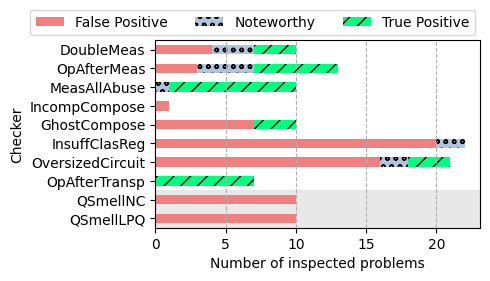

In [28]:
sample_size = 10

# create a stacked histogram of the number of inspected warnings per detector
fig, ax = plt.subplots(figsize=(5, 3))

# create dataframe with detection_rule, TP, Noteworthy, FP
# which come from detection_rule and triage
df = df_inspected_warnings.copy()
df['present_in_last_experiment'] = df['present_in_last_experiment'].astype(bool)
df = df[df['present_in_last_experiment']]
df_stacked_hist = df[['detector_rule', 'triage']]
# remove detectors corresponding to zero warnings
df_stacked_hist = df_stacked_hist[df_stacked_hist.sum(axis=1) != 0]
df_stacked_hist = df_stacked_hist.groupby(['detector_rule', 'triage']).size().reset_index(name='count')
df_stacked_hist = df_stacked_hist.pivot(index='detector_rule', columns='triage', values='count')
df_stacked_hist = df_stacked_hist.fillna(0)

# SORTING
# # add extra column with 0 for QSmell detectors and 1 for the others
# df_stacked_hist['detector_family'] = df_stacked_hist.index.map(
#     lambda e: 0 if e.startswith("QSmell") else 1)
# # sort by detector family
# df_stacked_hist = df_stacked_hist.sort_values(by=["TP", "Noteworthy", "FP"], ascending=False)
# df_stacked_hist = df_stacked_hist.sort_values(by=["detector_family"], ascending=True)
# convert from DoubleMeas (10/20) >> DoubleMeas
df_stacked_hist['auxiliary'] = df_stacked_hist.index
df_stacked_hist['rule'] = df_stacked_hist['auxiliary'].apply(
    lambda e: e.split(" (")[0])
# sort by canonical order
df_stacked_hist['rule'] = pd.Categorical(
    df_stacked_hist['rule'],
    categories=RULE_NAME_MAPPING.values())
df_stacked_hist = df_stacked_hist.sort_values('rule', ascending=False)
df_stacked_hist = df_stacked_hist.drop(columns=[
    'rule', 'auxiliary'])
# df_stacked_hist = df_stacked_hist.drop(columns=[
#     'detector_family'])

MAPPING_CATEGORY_NAMES = {
    "TP": "True Positive",
    "Noteworthy": "Noteworthy",
    "FP": "False Positive"
}
df_stacked_hist = df_stacked_hist.rename(columns=MAPPING_CATEGORY_NAMES)


df_stacked_hist.plot(
    kind='barh',
    stacked=True,
    color=['lightcoral', 'lightsteelblue', 'springgreen'],
    ax=ax 
)

# add the hatches to the bars.
# each color should have a different hatch
hatches_available = ['', 'oo', '//']
hatches_assigned = 0
all_colors = {}
for i, i_bar in enumerate(ax.patches):
    i_color = i_bar.get_facecolor()
    if i_color not in all_colors.keys():
        all_colors[i_color] = hatches_available[hatches_assigned]
        hatches_assigned += 1
    i_bar.set_hatch(all_colors[i_color]) 
    
# color the background to separate the two families
n_qsmell_detectors = len(
    df_stacked_hist[df_stacked_hist.index.str.startswith("QSmell")])
separation_line = n_qsmell_detectors - .5
plt.axhspan(separation_line, -1, facecolor='lightgrey', alpha=0.5, zorder = -1)

# remove title from the legend
plt.legend(
    title=None,
    loc='upper center', bbox_to_anchor=(0.3, 1.2), ncol=3)

# add the labels
plt.xlabel("Number of inspected problems")
plt.ylabel("Checker")

# add vertical grid
plt.grid(axis='x', linestyle='--')

# draw line at the sample size in red
# plt.axvline(x=sample_size, color='r', linestyle='--')
plt.tight_layout()
fig.savefig(
    os.path.join(PAPER_DIR, "precision_estimate_abs.pdf"), 
    bbox_inches="tight")

### RQ3.C Checkers Empirical Precision
Here we compute the empirical precision of each checker to get a relative measure to compare checkers which find different number of problems.

In [29]:
CONSIDER_NOTEWORTHY_AS_TP = True

df = df_inspected_warnings.copy()
df['present_in_last_experiment'] = df['present_in_last_experiment'].astype(bool)
df = df[df['present_in_last_experiment']]
if CONSIDER_NOTEWORTHY_AS_TP:
    df['triage'] = df['triage'].apply(
        lambda e: 'TP' if e == 'Noteworthy' else e)

# count the number of tp / the total number of inspected warnings
df_inspected_tp_warnings = df[df['triage'] == 'TP']
df_inspected_tp_warnings_count = \
    df_inspected_tp_warnings.groupby('detector_rule').agg({'triage': 'count'})  
df_inspected_tp_warnings_count.reset_index(inplace=True)
df_inspected_tp_warnings_count.rename(columns={'triage': 'tp'}, inplace=True)

# count total inspection per detector_rule
df_inspected_warnings_count = \
    df.groupby('detector_rule').agg({'triage': 'count'})
df_inspected_warnings_count.reset_index(inplace=True)
df_inspected_warnings_count.rename(columns={'triage': 'total'}, inplace=True)

# merge
df_precision = pd.merge(
    df_inspected_tp_warnings_count,
    df_inspected_warnings_count,
    how='right',
    on='detector_rule',
)
df_precision.fillna(0, inplace=True)

df_precision['tp'] = df_precision['tp'].fillna(0).astype(int)
df_precision['total'] = df_precision['total'].fillna(0).astype(int)
df_precision['num_precision'] = (df_precision['tp'] / df_precision['total']).fillna(0)
df_precision['precision'] = (df_precision['tp'] / df_precision['total']) * 100
df_precision['precision'] = df_precision['precision'].fillna('~')
# as percentage with a decimal
df_precision['precision'] = df_precision['precision'].apply(lambda e: f"{e:.2f}%")
# rename: detector_rule > rule
df_precision = df_precision.rename(columns={'detector_rule': 'rule'})

# FOCUS on LintQ precision only
df_precision_lintq = df_precision[
    ~df_precision['rule'].str.startswith('QSmell')]

median_precision = df_precision_lintq['num_precision'].median() * 100
print("\\newcommand{\\medianPrecisionLintQ}{" + f"{median_precision:.1f}" + "\%}")
mean_precision = df_precision_lintq['num_precision'].mean() * 100
print("\\newcommand{\\avgPrecisionLintQ}{" + f"{mean_precision:.1f}" + "\%}")
min_precision = df_precision_lintq['num_precision'].min() * 100
print("\\newcommand{\\minPrecisionLintQ}{" + f"{min_precision:.1f}" + "\%}")
max_precision = df_precision_lintq['num_precision'].max() * 100
print("\\newcommand{\\maxPrecisionLintQ}{" + f"{max_precision:.1f}" + "\%}")

bad_checkers = ['OversizedCircuit']
df_precision_lintq_best_checkers = df_precision_lintq[
    ~df_precision_lintq['rule'].isin(bad_checkers)]
median_precision = df_precision_lintq_best_checkers['num_precision'].median() * 100
print("\\newcommand{\\medianPrecisionLintQBestCheckers}{" + f"{median_precision:.1f}" + "\%}")
mean_precision = df_precision_lintq_best_checkers['num_precision'].mean() * 100
print("\\newcommand{\\avgPrecisionLintQBestCheckers}{" + f"{mean_precision:.1f}" + "\%}")


overall_precision = (
    df_precision_lintq['tp'].sum() / df_precision_lintq['total'].sum()) * 100
print("\\newcommand{\\overallPrecisionLintQ}{" + f"{overall_precision:.1f}" + "\%}")
overall_precision_best_checkers = (
    df_precision_lintq_best_checkers['tp'].sum() / df_precision_lintq_best_checkers['total'].sum()) * 100
print("\\newcommand{\\overallPrecisionLintQBestCheckers}{" + f"{overall_precision_best_checkers:.1f}" + "\%}")

df_precision

\newcommand{\medianPrecisionLintQ}{45.0\%}
\newcommand{\avgPrecisionLintQ}{50.0\%}
\newcommand{\minPrecisionLintQ}{0.0\%}
\newcommand{\maxPrecisionLintQ}{100.0\%}
\newcommand{\medianPrecisionLintQBestCheckers}{60.0\%}
\newcommand{\avgPrecisionLintQBestCheckers}{53.7\%}
\newcommand{\overallPrecisionLintQ}{45.7\%}
\newcommand{\overallPrecisionLintQBestCheckers}{52.1\%}


,rule,tp,total,num_precision,precision
0,DoubleMeas,6,10,0.600000,60.00%
1,GhostCompose,3,10,0.300000,30.00%
2,IncompCompose,0,1,0.000000,0.00%
3,InsuffClasReg,2,22,0.090909,9.09%
4,MeasAllAbuse,10,10,1.000000,100.00%
5,OpAfterMeas,10,13,0.769231,76.92%
6,OpAfterTransp,7,7,1.000000,100.00%
7,OversizedCircuit,5,21,0.238095,23.81%
8,QSmellLPQ,0,10,0.000000,0.00%
9,QSmellNC,0,10,0.000000,0.00%


# RQ5: Efficiency

In [30]:

# READ LOG DATA
log_content = open(LOG_FILE_QUERIES, 'r').read()
log_content_db = open(LOG_FILE_DB_CREATION, 'r').read()

# modules in 4447.50s
for db_log_line in log_content_db.splitlines():
    if " modules in " in db_log_line:
        #print(db_log_line)
        total_time_db = float(re.findall(r'modules in (\d+\.?\d+?)s', db_log_line)[0])


# a line looks like this
# [1/14 comp 9.1s] Compiled /home/.../codeql/src/Interconnection/GhostComposition.ql.
# parse the time and the file name
lines = log_content.splitlines()
compilation_lines = [l for l in lines if "Compiled" in l]
compilation_times = {
    re.findall(r'([a-zA-Z]+)\.ql\.$', l)[0] : float(re.findall(r'(\d+\.?\d?)s', l)[0])
    for l in compilation_lines
}
evaluation_lines = [l for l in lines if "Evaluation done" in l]
evaluation_times = {}
for l in evaluation_lines:
    key =  re.findall(r'([a-zA-Z]+)\.bqrs\.$', l)[0]
    seconds = float(re.findall(r'(\d+\.?\d?)s', l)[0])
    if minutes_regex := re.findall(r'(\d+\.?\d?)m', l):
        seconds += float(minutes_regex[0]) * 60
    evaluation_times[key] = seconds
evaluation_times

# create a dataframe with the compilation and evaluation times
df_times = pd.DataFrame.from_dict(
    {
        'compilation_time': compilation_times,
        'evaluation_time': evaluation_times
    }
)
df_times.reset_index(inplace=True)
df_times.rename(columns={'index': 'detector_rule'}, inplace=True)

# remove blacklisted detectors
BLACKLISTED_QUERY = [
    'NonParametrizedCircuit',
    'TokenLeakage',
    'NoAlignmentLogicalPhysical',
    'InvalidPauliSyntaxError',
    'InvalidPauliErrorSize',
]
df_times = df_times[
    ~df_times['detector_rule'].isin(BLACKLISTED_QUERY)]
df_times.reset_index(drop=True, inplace=True)

avg_comp_time = df_times['compilation_time'].mean()
avg_exec_time = df_times['evaluation_time'].mean()
print("\\newcommand{\\avgPerDetectorQueryCompilationTimeSec}{" + f"{avg_comp_time:.1f}" + "}")
print("\\newcommand{\\avgPerDetectorEvaluationTimeSec}{" + f"{avg_exec_time:.1f}" + "}")

total_comp_time = df_times['compilation_time'].sum()
total_exec_time = df_times['evaluation_time'].sum()
total_exec_time_min = total_exec_time / 60
print("\\newcommand{\\totalDatasetQueryCompilationTimeSec}{" + f"{total_comp_time:.1f}" + "}")
print("\\newcommand{\\totalDatasetEvaluationTimeSec}{" + f"{total_exec_time:.1f}" + "}")
print("\\newcommand{\\totalDatasetEvaluationTimeMin}{" + f"{total_exec_time_min:.0f}" + "}")


total_time_db_min = total_time_db / 60
print("\\newcommand{\\totalDatasetCreationTimeSec}{" + f"{total_time_db:.1f}" + "}")
print("\\newcommand{\\totalDatasetCreationTimeMin}{" + f"{total_time_db_min:.0f}" + "}")

normalized_time_per_query = total_exec_time / TOTAL_FILES_IN_DATASET
print("\\newcommand{\\avgPerProgramEvaluationTimeSec}{" + f"{normalized_time_per_query:.1f}" + "}")

df_times

\newcommand{\avgPerDetectorQueryCompilationTimeSec}{6.5}
\newcommand{\avgPerDetectorEvaluationTimeSec}{575.9}
\newcommand{\totalDatasetQueryCompilationTimeSec}{58.4}
\newcommand{\totalDatasetEvaluationTimeSec}{5182.8}
\newcommand{\totalDatasetEvaluationTimeMin}{86}
\newcommand{\totalDatasetCreationTimeSec}{4447.5}
\newcommand{\totalDatasetCreationTimeMin}{74}
\newcommand{\avgPerProgramEvaluationTimeSec}{0.7}


,detector_rule,compilation_time,evaluation_time
0,GhostComposition,9.1,53.7
1,UngovernedComposition,5.3,42.8
2,IncompatibleComposition,5.3,43.8
3,OpAfterOptimization,4.4,43.8
4,MeasureAll,7.0,51.9
5,OpAfterMeasurement,7.0,3328.0
6,DoubleMeasurement,7.2,1426.0
7,UnmeasurableQubits,6.0,43.8
8,OversizedCircuit,7.1,149.0


In [31]:
# get the top three detector rules per evaluation time
df = df_times.copy()
df.sort_values(by='evaluation_time', ascending=False, inplace=True)
df = df.head(3)
number_prefixes = ['One', 'Two', 'Three']
i = 0
for _, row in df.iterrows():
    name = row['detector_rule']
    time = row['evaluation_time']
    print("\\newcommand{\\topThreeDetectorRule" + str(number_prefixes[i]) + "}{" + name + "}")
    print("\\newcommand{\\topThreeDetectorRule" + str(number_prefixes[i]) + "TimeSec}{" + f"{time:.1f}" + "}")
    i += 1



\newcommand{\topThreeDetectorRuleOne}{OpAfterMeasurement}
\newcommand{\topThreeDetectorRuleOneTimeSec}{3328.0}
\newcommand{\topThreeDetectorRuleTwo}{DoubleMeasurement}
\newcommand{\topThreeDetectorRuleTwoTimeSec}{1426.0}
\newcommand{\topThreeDetectorRuleThree}{OversizedCircuit}
\newcommand{\topThreeDetectorRuleThreeTimeSec}{149.0}
